### Installing stuff and importing libraries.

This notebook uses my `dask_dp4gp` module for the `install_libraries_on_workers` utility function and uses my `hypercuboid_integrator`. It also uses `dask`, etc to distribute the computation. So to install:

        git clone https://github.com/lionfish0/GPAdversarialBound.git
        cd GPAdversarialBound
        pip install -e .
        pip install git+https://github.com/lionfish0/hypercuboid_integrator.git
        pip install dask
        pip install git+https://github.com/lionfish0/dask_dp4gp.git

You'll probably want to skip the distributed aspect however. To do that simply remove the `ip=ip` parameter from the call to `getshiftbounds`. All the distribution does is compute each pixel on a separate server.

In [1]:
from GPAdversarialBound import getshiftbounds, getpred, plot2dB
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ip = None #'54.194.231.31'

In [3]:
ip = '34.242.232.253'
from dask_dp4gp import install_libraries_on_workers as ilow
joblist = ['pip install -U pip','sudo apt install libgl1-mesa-glx -y','conda update scipy -y','pip install git+https://github.com/sods/paramz.git','pip install git+https://github.com/SheffieldML/GPy.git','pip install git+https://github.com/lionfish0/dp4gp.git','conda install dask-searchcv -c conda-forge -y', 'pip install git+https://github.com/lionfish0/dask_dp4gp.git', 'pip install numpy', 'conda remove argcomplete -y', 'pip install -U pip', 'pip install numpy', 'conda remove argcomplete -y', 'pip install git+https://github.com/lionfish0/hypercuboid_integrator.git','pip install git+https://github.com/lionfish0/GPAdversarialBound.git']
ilow(ip+':8786',joblist)

distributed.utils - ERROR - Timed out trying to connect to 'tcp://34.242.232.253:8786' after 5 s: connect() didn't finish in time
Traceback (most recent call last):
  File "/home/mike/anaconda3/lib/python3.6/site-packages/distributed/comm/core.py", line 185, in connect
    quiet_exceptions=EnvironmentError)
  File "/home/mike/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home/mike/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.gen.TimeoutError: Timeout

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mike/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 238, in f
    result[0] = yield make_coro()
  File "/home/mike/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  

OSError: Timed out trying to connect to 'tcp://34.242.232.253:8786' after 5 s: connect() didn't finish in time

## The algorithm

We're interested in how much one input axis can change a prediction. Thus we are interested in the *gradient* of the prediction wrt the inputs. If we break down the space of inputs into hypercubes and consider the gradient within each of these cubes we can then find the largest value that moving across the space would cause by adding up the `gradient*cube-width`. So we just need to:
1. find a bound on the gradient within an arbitrary hypercube.
2. split the space in an efficient way to minimise the `gradient*width` values.
3. sum over the whole space, finding a path along each dimension that maximises the prediction change.

### Details

Consider a GP as $\sum{\alpha_i} \text{k}(\mathbf{x_i},\mathbf{x_*})$
where $\mathbf{\alpha} = K^{-1}\mathbf{y}$

We are interested in the greatest gradient.

So we differentiate the whole thing by $x_{*d}$,

Which, for the RBF kernel, gives us:

$$\sum{\frac{\alpha_i}{l^2} (x_{id} - x_{*d}) \text{k}(\mathbf{x_i},\mathbf{x_*})}$$

If the lengthscales are different on different dimensions, then $l$ is the lengthscale of dimension $d$.

To find a bound on the maximum inside a box, with bounds $b_i \leq x_{*i} \leq b_i'$ we do the following steps:

First, we just consider one input $\mathbf{x_i}$ at a time.

1. First consider dimension $d$. The maximum is at location $x_{id} - l \text{sign}({y})$.
2. Test whether this location is within $b_d$ and $b_d'$.
3. If it isn't, compute the value at $b_d$ and $b_d'$ (with all the other values of $x_{*j}$ set to the values of $x_{ij}$).
4. If one or more of the values is positive, select the largest (most positive). The other values of $x_{*j}$ set to the values of $x_{ij}$, or if these lie outside $b_j$ $b_j'$ set to the value of $b_j$ or $b_j'$ closest to $x_{ij}$
5. If both the values are negative, then select the most positive. The other values of $x_{*j}$ should be set to those values of $b_j$ and $b_j'$ that are as far from $x_{ij}$.
 
This gives us the value of that element of the sum which is largest inside the box.

We then repeat 1-5 for each input $x_i$ $(i=1..N)$.

We finally have, for a box, a list of values telling us the largest value the gradient can be for each term in the sum. We simply sum these to get an upper bound on the sum of the elements and hence the gradient in that direction, in that box.

We split the input domain into a series of boxes (note that with the RBF kernel the above gradient will tend to zero at infinity) and find the bound in each. We repeat this for a value of $d=1..D$.

We can finally find the largest change in output a change in one axis can cause. We are interested in a line across the domain in direction of axis $d$ such that the greatest increase occurs, while adding up all the boxes... so imagine we have a 2d space, that is split into 4 boxes,

<pre>
 6acros 3acr
|------|---|
|   2  | 3 |
|------|---|
|   3  | 4 |
|==========>
|------|---|
</pre>

The bounds on the gradient are written in the box. So we can see that the largest change maybe is a line in the bottom two boxes (indicated by the =====>). The first box is width 6 and has max gradient 3 so a change of up to 18 occured there. The second box has a max change of 12. So the total change is 30.

We might want to split the first box in half, and find closer bounds... etc.

# GP Adversarial Bound Demo

We consider a very simple 2d example with four datapoints, on four corners of a 1x1 square. Three of the points are 1, while one point (at [1,1]) is -1:

```
   1|1         -1
    |
    |   
    |
   0|1__________1
     0          1
```
We set the lengthscale to 1 and the the value of $\sigma^2$ is currently fixed in the code to 1.0.

The kernel is an RBF kernel (this is a necessary aspect of the current mathematical derivation).

--


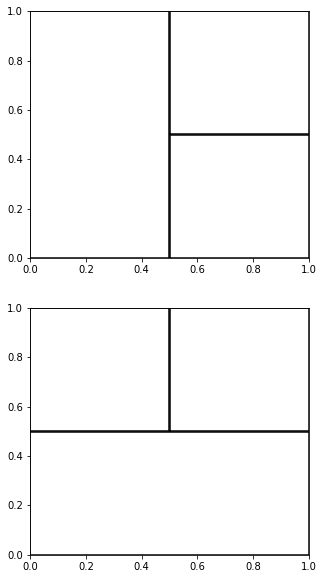

In [2]:
l = 1.0
X = np.array([[0,0],[0,1],[1,0],[1,1]])*1.0
Y = np.array([[1,1,1,-1]]).T*1.0

#positive Y:
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=3,ip=ip)
#print(pos_allshifts)
#negative Y:
print("--")
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=3,ip=ip)
#print(neg_allshifts)

plt.figure(figsize=[5,10])
plt.subplot(2,1,1)
plot2dB(neg_dbinfo[0]['B'])

plt.subplot(2,1,2)
plot2dB(neg_dbinfo[1]['B'])

#### Testing for symmetry

As this is symmetric, half the iterations should have a higher bound on one dimension and half on the other.

In [3]:
s = 0
t = 0
N = 100
for temp in range(N):
    neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=3,ip=ip)
    s+=((np.random.randn()*0.001+np.diff(neg_allshifts))>0)
    t+=((np.random.randn()*0.001+np.diff(neg_allshifts))<0)
print(s/N,t/N)

[ 0.5] [ 0.6]


### Interpretation

We have first asked for an upper bound on the greatest increase in the prediction over the two dimensions. Because the gradient is basically never positive in the 0 to 1 domain, the algorithm has found an upper bound of zero.

The story is very different if we include, for example the region from -1 to 1. In this case there is considerable positive gradient available from -1 (as the predictions climb from the prior mean towards the positive training data), similarly if we include the domain from 1 to 2, there's positive gradient as the predictions return to the prior from the negative sample, at [1,1].

By inverting Y, we can perform the same analysis for the decrease in the prediction (with respect to the training inputs).

To help see things more clearly let's plot the predictions:

I've plotted points that are greater than 0.6 or less than 0.

/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


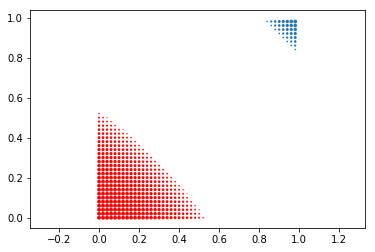

In [4]:
Xtest = []
for x1 in np.arange(0,1,0.02):
    for x2 in np.arange(0,1,0.02):
        Xtest.append([x1,x2])
Xtest = np.array(Xtest)
preds = getpred(Xtest,X,Y,l)
plt.scatter(Xtest[:,0],Xtest[:,1],-100*preds,label='<0.0')
plt.scatter(Xtest[:,0],Xtest[:,1],-60+100*preds,c='r',label='>0.6')
plt.axis('equal');

This simply shows how the predictions vary over the domain. As one can see the gradient is negative for both inputs.

Let's see how much the predictions change for these test points. As the problem is symmetrical I'll just consider one axis.

Here I'm plotting the data - but all on the same graph, effectively each line is for one value of input 0, showing the predictions as input 1 changes. The lower lines are for when input 0 is near 1 (where the negative training point lies) and the right hand side of the plot is near one (bringing us closer to the negative training point).

Text(0.5,1,'Predictions')

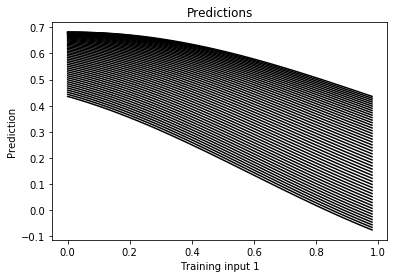

In [5]:
plt.plot(np.arange(0,1,0.02),np.reshape(preds,[50,50]),'k-');
plt.xlabel('Training input 1')
plt.ylabel('Prediction')
plt.title('Predictions')

The biggest change for any of these 'slices' we can find the approximate value of:

In [6]:
np.max(np.max(np.reshape(preds,[50,50]),0)-np.min(np.reshape(preds,[50,50]),0))

0.51058772000662833

Our upper bound above was 0.55758 which is greater than this empirical value (phew!).

### What does this mean practically?

Our bound means that we can only change the prediction by up to 0.56 by changing one of the inputs.

If we want to move from a very positive value, of 0.6, to the smallest value in the domain of about 0. We would need to change both training points. As 0.6>0.56.

One can see this in the earlier 2d plot: To get from the region greater than 0.6, to the region of less than 0 can't be done by changing just one input.

### Detour: Current Debug Concern...

Given the problem is symmetric for the two input dimensions; I'm worried why the two bounds are different for the two dimensions. I think this indicates there might be a programming error. We need to find where this asymmetry arises.


### 5d example

To extend the 2d example above slightly, we consider ten data points, at some of the 32 corners of a 5d unit hypercube. Lengthscale = 0.3

In [7]:
l = 0.3
X = np.array([[0,0,0,0,0],[0,0,1,0,0],[1,0,0,0,0],[1,0,0,0,1],[1,0,0,1,0],[1,0,1,0,1],[0,1,1,0,1],[1,1,0,1,1],[0,1,1,1,1],[1,1,1,1,1]])*1.0
Y = np.array([[-1,-1,-1,-1,-1,1,1,1,1,1]]).T*1.0

#positive Y:
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=2000,ip=ip)
print(pos_allshifts)
#negative Y:
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=2000,ip=ip)
print(neg_allshifts)

(50/2000)
(150/2000)
(250/2000)
(350/2000)


KeyboardInterrupt: 

The positive and negative shifts possible in the five dimension are listed. We should consider the largest for each dimension. Running the algorithm for longer might push these bounds down, but takes time.

How do these values compare to the actual changes possible, and what does it mean for the number of dimensions we'd need to change?

If we look at the predictions at the ten data points (probably this is close to the 'extremes' of the range of predictions) we can see that the prediction can change by about 1.0. We arbitrarily consider then a change of 90% of the full change in the prediction value (0.9) to be sufficient to go from one confident class to another. Disappointingly it seems the prediction can go from one class to another with the change of just one input (the 3rd).

In [10]:
getpred(X,X,Y,l)

array([[-0.50193295],
       [-0.500959  ],
       [-0.50289382],
       [-0.49999625],
       [-0.5009646 ],
       [ 0.49903352],
       [ 0.50096647],
       [ 0.50095901],
       [ 0.50193108],
       [ 0.50193482]])

Maybe our bounds are excessively large? We here consider a lower bound on the change by looking at the empirical values for the predictions. We can see that the prediction can change by at least 0.999 by changing the third input. Maybe our bound is a little too high (1.19), and needs to be made closer to the actual value.

In [12]:
maxchange = 0
for x1 in np.arange(0,1.001,0.2):
    for x2 in np.arange(0,1.001,0.2):
        for x4 in np.arange(0,1.001,0.2):
            for x5 in np.arange(0,1.001,0.2):
                Xtest = []
                for x3 in np.arange(0,1.001,0.05):
                    Xtest.append([x1,x2,x3,x4,x5])
                Xtest = np.array(Xtest)
                preds = getpred(Xtest,X,Y,l)
                maxchange=max(maxchange,(max(preds)-min(preds)))
print(maxchange)

[ 0.99902977]


Does increasing the lengthscale help?

In [13]:
l = 2.0 #instead of 0.3

In [14]:
#positive Y:
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=2000)
print(pos_allshifts)
#negative Y:
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=2000)
print(neg_allshifts)


[0.20168044808520585, 0.58150637248317649, 0.4914559923078024, 0.34913569629146424, 0.59973673112725279]

[0.15134496211660131, 0, 0, 0.0034721390672939464, 0]


In [15]:
maxchange = 0
for x1 in np.arange(0,1.001,0.2):
    for x2 in np.arange(0,1.001,0.2):
        for x4 in np.arange(0,1.001,0.2):
            for x5 in np.arange(0,1.001,0.2):
                Xtest = []
                for x3 in np.arange(0,1.001,0.05):
                    Xtest.append([x1,x2,x3,x4,x5])
                Xtest = np.array(Xtest)
                preds = getpred(Xtest,X,Y,l)
                maxchange=max(maxchange,(max(preds)-min(preds)))
print(maxchange)

[ 0.33230797]


In [16]:
preds = getpred(X,X,Y,l)
print(preds)
max(preds)-min(preds)

[[-0.59821301]
 [-0.3174621 ]
 [-0.5847893 ]
 [-0.20780537]
 [-0.41833905]
 [ 0.11807495]
 [ 0.44125327]
 [ 0.34000354]
 [ 0.58984378]
 [ 0.62064364]]


array([ 1.21885665])

The predictions can change by 1.22 (if we scale by 0.9 again that's 1.098). We now need at least two inputs to change (specifically the 2nd, 3rd or 5th input) to cause this change. So increasing the lengthscale does appear to have helped a little.

Ways to make this quicker:

1. Maybe we should slice up the space more efficiently.
2. Pick on those dimensions with the highest bounds first.

Quickly looking at an even longer lengthscale (of 4.0).

In [17]:
l = 4.0 #instead of 0.3 or 2.0
#positive Y:
print("Upper Bounds on change in inputs on prediction:")
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=2000)
print(pos_allshifts)
#negative Y:
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=2000)
print(neg_allshifts)

print("Lower bound on effect of 3rd input")
maxchange = 0
for x1 in np.arange(0,1.001,0.2):
    for x2 in np.arange(0,1.001,0.2):
        for x4 in np.arange(0,1.001,0.2):
            for x5 in np.arange(0,1.001,0.2):
                Xtest = []
                for x3 in np.arange(0,1.001,0.05):
                    Xtest.append([x1,x2,x3,x4,x5])
                Xtest = np.array(Xtest)
                preds = getpred(Xtest,X,Y,l)
                maxchange=max(maxchange,(max(preds)-min(preds)))
print(maxchange)

print("Actual predictions at training locations")
preds = getpred(X,X,Y,l)
print(preds)
print("Biggest actual change in these predictions")
max(preds)-min(preds)

Upper Bounds on change in inputs on prediction:

[0.066745745337653928, 0.24275593172327753, 0.19975163699534149, 0.14785710474294567, 0.2462846049389881]

[0.058157635615308567, 0, 0, 0, 0]
Lower bound on effect of 5th input
[ 0.13850615]
Actual predictions at training locations
[[-0.28143466]
 [-0.14772808]
 [-0.27805889]
 [-0.09932869]
 [-0.19381064]
 [ 0.03786542]
 [ 0.20770426]
 [ 0.16161878]
 [ 0.29030614]
 [ 0.29530332]]
Biggest actual change in these predictions


array([ 0.57673798])

To summarise - with this much longer length scale the prediction can only change by 0.58. The arbitrary 90% of this change is 0.519. The bounds on the effect the inputs can cause are also less though. The two largest inputs can't change a prediction by 0.519 - thus we need **three** inputs of the five to change, to change the classification from a confident one of one class to a confident classification in the other class.

We can see that increasing the lengthscale increases the lower bound on the number of training points we need to change.

We can also upper bound this, for these simple problems, by finding adversarial samples. Thus we maybe can show, for example, that increasing the lengthscale provably increases the 'robustness' of the classifier to adversarial examples.

In summary an increase in lengthscale can help! But let's look at more dimensions...

## MNIST example

We demonstrate the tool with a more complex example, the MNIST dataset, which we scale to be 5x smaller and just look at a few ones and zeros.

In [30]:
ip=None

In [4]:
from mnist import MNIST
#download the mnist data from http://yann.lecun.com/exdb/mnist/
#save in mnistdata folder in same directory as this notebook

def getMNISTexample(scalingfactor=7):
    mndata = MNIST('./mnistdata')
    mnist_training = mndata.load_training()

    #B = [np.array([[-10.0,20.0],[-10.0,20.0]])]
    bigX = np.array(mnist_training[0])[np.array(mnist_training[1])<2,:]
    bigXtest = bigX[91:100,:]
    bigX = bigX[0:90,:]
    Y = np.array(mnist_training[1])[np.array(mnist_training[1])<2]
    Y = Y[:,None]*2.0-1.0
    Ytest = Y[91:100,:]
    Y = Y[0:90,:]

    def scale(X,res):
        newX = []
        for x in X:
            newx = np.zeros([1+int(28/res),1+int(28/res)])
            xreshaped = x.reshape(28,28)
            for newi,i in enumerate(np.arange(0,28,res)):
                for newj,j in enumerate(np.arange(0,28,res)):
                    newx[newi,newj] = np.mean(xreshaped[i:(i+res),j:(j+res)])
            newX.append(newx.reshape(newx.size))
        return np.array(newX)

    X = scale(bigX,scalingfactor)
    Xtest = scale(bigXtest,scalingfactor)
    newres = int(X[0,:].size**.5)
    return X,Y,Xtest,Ytest

for totalits in [50]:
    print("------------------------------")
    print("%d" % totalits)
    X,Y,Xtest,Ytest = getMNISTexample(scalingfactor=10)
    print(X.shape)
    #positive Y:
    ###l = 2400.0
    l = 15.0
    pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=totalits,valmax=255,dimensions=[4], ip=ip)
    print(pos_allshifts)
    #negative Y:
    neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=totalits,valmax=255,dimensions=[4], ip=ip)
    print(neg_allshifts)
    print("Max of both")
    print(np.sort(np.max(np.c_[pos_allshifts,neg_allshifts],1))[::-1])

------------------------------
50
(90, 9)
(50/161)
(150/161)
[53.27781566615316]
(50/154)
(150/154)
[50.803168956648037]
Max of both
[ 53.27781567]


In [5]:
import GPy
X,Y,Xtest,Ytest = getMNISTexample(scalingfactor=10)
valmax = np.ones(X.shape[1])
for it in range(3):
    k = GPy.kern.RBF(9,ARD=True)
    m = GPy.models.GPRegression(X,Y,k)
    m.optimize()
    valmax /= m.kern.lengthscale
    X /= m.kern.lengthscale

 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


In [51]:
l = 1.0
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=5,valmax=valmax.tolist(), ip=ip)
print(pos_allshifts)
#negative Y:
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=5,valmax=valmax.tolist(), ip=ip)
print(neg_allshifts)
print("Max of both")
print(np.sort(np.max(np.c_[pos_allshifts,neg_allshifts],1))[::-1])

(50/97)
(50/84)
(50/73)
(50/91)
(50/64)
(50/62)
[0.0018802266841285941, 8.6392836845346316e-16, 6.0474492580439486e-15, 0, 3.5403067621710912e-16, 4.2868552718381365e-14, 0.022806510622190176, 5.682939442548615e-16, 7.3906420638072969e-15]
(50/78)
[0, 0, 0, 0.14707029282907882, 0, 2.1766613691403971e-14, 0, 0, 0]
Max of both
[  1.47070293e-01   2.28065106e-02   1.88022668e-03   4.28685527e-14
   7.39064206e-15   6.04744926e-15   8.63928368e-16   5.68293944e-16
   3.54030676e-16]


In [54]:
maxes = np.max(np.c_[pos_allshifts,neg_allshifts],1)/valmax

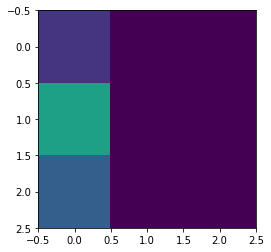

In [59]:
plt.imshow(maxes.reshape([3,3]))
plt.clim([0,1])

In [61]:
np.set_printoptions(suppress=True)
maxes

array([  1.53049804e-01,   1.60927563e-07,   1.53282008e-07,
         5.68548146e-01,   1.75440793e-07,   2.73965150e-07,
         3.02754017e-01,   1.33475982e-07,   2.54383511e-07])

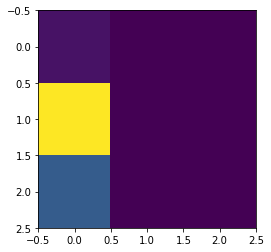

In [58]:
plt.imshow(np.array(valmax).reshape(3,3))

9 PIXELS!
LENGTHSCALE = 15.
50its = 57.759
100its = 38.59
200its = 30.46
400its = 23.79
800its = 18.44
x
3200its = 

LENGTHSCALE 15 (actual change available ~1.08)
totalits = 150, lengthscale = 15. 16 pixels.
46.5 [pixel 9]
totalits = 1000, lengthscale = 15. 16 pixels.
23.18 [pixel 9]
totalits = 2000, ...
19.88 [pixel 9]

LENGTHSCALE 40 (actual change available ~2)
totalits = 2000, lengthscale = 40. 16 pixels.
16.809 [pixel 9]
totalits = 1000, lengthscale = 40. 16 pixels.
17.46 [pixel 9]

totalits = 500, lengthscale = 40. 16 pixels.
[ 20.61167695  20.51002419  18.64405545  18.61597592  17.35274751
  16.38222626  15.92119635  13.95509815  12.95139176  12.86343681
  12.76899228  12.54592965  12.46713479  12.10651117  11.5002078
  11.27811593]



LENGTHSCALE 200 (actual change available ??)
totalits = 100, lengthscale = 200. 16 pixels
[ 12.80110506  12.7663646   12.6338846   12.34834885  11.27531682
  10.90766498  10.65270014  10.56035841  10.30909176  10.2943159
  10.13909973  10.08172315  10.07844784  10.06780549  10.06673362
  10.00778699]

totalits = 500, lengthscale = 200. 16 pixels [~3 minutes x 2 + overhead < 10 mins]
[ 11.59228096  11.4269993   11.17482736  10.90167401  10.77480208
  10.56178454  10.55687932  10.40495974  10.30698279  10.14533829
  10.04870913   9.97438643   9.95813241   9.94685383   9.8857553
   9.79416254]

totalits = 1000, lengthscale = 200. 16 pixels
[ 11.48017764  11.43593677  10.80798835  10.75883776  10.66081845
  10.38293052  10.30699542  10.27032344  10.07192226  10.06668644
  10.02374089   9.97448159   9.92996086   9.88875628   9.80800128
   9.79090597]

25 pixels:
totalits = 100, lengthscale = 200.
[ 14.14587839  13.33175138  13.32608428  12.6599913   12.08762631
  11.70736261  11.4580155   11.2560345   10.83212891  10.4295094
  10.19903042  10.19020441   9.99829114   9.95804711   9.95804468
   9.95801665   9.95612598   9.95612427   9.95608998   9.93681955
   9.92907191   9.92759449   9.90960877   9.88238168   9.82794206]


from totalits = 180...lengthscale=2400
        Max of both
        [ 0.5874921   0.56818688  0.56129305  0.53670019  0.52470125  0.51144551
          0.48880568  0.44562814  0.43721578  0.42611792  0.41578221  0.41548644
          0.41472339  0.40932994  0.40602355  0.40489007  0.40426588  0.40305009
          0.4029622   0.40240853  0.40161357  0.40158691  0.40147937  0.40056012
          0.39791116]
  
from totalits = 450... almost the same as above.

These bounds suggest that we only need to change two pixels to achieve a large change in the prediction.

In [22]:
#import pickle
#pickle.dump({'pos_allshifts':pos_allshifts,'pos_dbinfo':pos_dbinfo,'neg_allshifts':neg_allshifts,'neg_dbinfo':neg_dbinfo},open('mnist_bound_example.p','wb'))

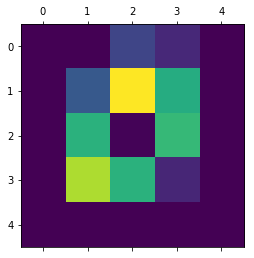

In [23]:
plt.matshow(np.reshape(X[0,:],[5,5]))

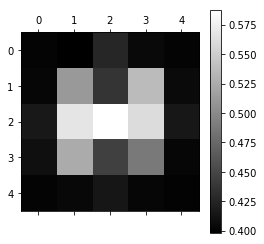

In [24]:
plt.matshow(np.reshape(np.max(np.c_[neg_allshifts,pos_allshifts],1),[5,5]),cmap='gray')
plt.colorbar()

The above plot shows the value of the bound for each pixel.
**BUG**: I find the dark patch at the top a bit dubious and wonder if there's a bug?

Only two pixels changing to cause an adversarial sample seems maybe unlikely, but we can check by bruteforce search (flipping every possible pair of pixels).

In [9]:
preds = getpred(Xtest,X,Y,l)
np.max(preds)-np.min(preds)

1.0764346339068209

## Bruteforce

Here we just set all combinations of two pixels to 255.

*This isn't necessarily going to give us the largest change two pixels can cause, as there might be intermediate values that cause greater changes to the prediction (the GP regression isn't a linear sum of the pixels).*

[[-0.91929264]]
[ 0.]


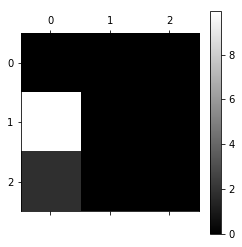

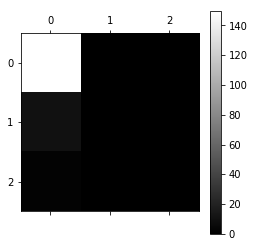

In [63]:
confident = np.argmax(-(1-Y)*(getpred(X,X,Y,l)))
advX = X[confident:(confident+1),:].copy() #the initial test point we're going to use...
width = 3
plt.matshow(advX.reshape(width,width),cmap='gray')
plt.colorbar()
print(getpred(advX,X,Y,l))
N = width*width
adv = advX.copy()
for it in range(1):
    adv = adv.repeat(N,0)
    for i in range(N):
        adv[i::N,i]=150
        
bigest = -np.Inf
bigestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(1):
        b = b.repeat(N,0)
        for i in range(N):
            b[i::N,i]=150
    preds = getpred(b,X,Y,l)
    minpredi = np.argmax(preds)
    if (preds[minpredi]>bigest):
        bigest = preds[minpredi]
        bigestim = b[minpredi]        
        
print(bigest)
plt.matshow(bigestim.reshape(width,width),cmap='gray')
plt.colorbar()

Adding two pixels (interestingly at the locations the earlier bounds found had the largest effect) cause this training point for a 1 to be reclassified as a 0, but not confidently. However as I mentioned there might be more effective perturbations of the same magnitude.

# Summary

- The method allows us to put bounds on how robust a GP regression model is (with an RBF kernel).
- For the examples given one might argue the brute-force search is better, but we should maybe show that these don't properly search the whole space of perturbation.
- We found that lengthscale interacted as we expected, with a short lengthscale, only one of five inputs needed to change, with an intermediate lengthscale two had to change, and with a long lengthscale three had to change.